# Demo Document Classification
Dataset: https://www.kaggle.com/datasets/sunilthite/text-document-classification-dataset

In [7]:
import requests
import pandas as pd

API_BASE_URL = "http://localhost:8000"
COLLECTION_NAME = "test10"
CSV_PATH = r"C:\Users\sneee\Desktop\demo\dataset.csv"
ID_COL = "Label"   # ground-truth class id

label2id = {
    "Politics": 0,
    "Sport": 1,
    "Technology": 2,
    "Entertainment": 3,
    "Business": 4,
}

In [8]:
df = pd.read_csv(CSV_PATH)
df["Predicted"] = None
df["row_id"] = df.index
df.head()

,Text,Label,Predicted,row_id
0,Budget to set scene for election\n \n Gordon B...,0,None,0
1,Army chiefs in regiments decision\n \n Militar...,0,None,1
2,Howard denies split over ID cards\n \n Michael...,0,None,2
3,Observers to monitor UK election\n \n Minister...,0,None,3
4,Kilroy names election seat target\n \n Ex-chat...,0,None,4


In [9]:
# Get labels from collection
r = requests.get(
    f"{API_BASE_URL}/collections/{COLLECTION_NAME}/labels",
    params={"limit": 1000, "use_cache": True},
)
labels = [i["label"] for i in r.json()["labels"]]
labels

['Business', 'Entertainment', 'Politics', 'Sport', 'Technology']

In [10]:
# Get points for each label
for label in labels:
    print(f"Fetching docs for {label}")
    id = label2id[label]
    r = requests.get(
        f"{API_BASE_URL}/collections/{COLLECTION_NAME}/labels/{label}",
        params={"limit": 10000}
    )
    rows = [
        int((i.get("source") or "").rsplit("-", 1)[-1])
        for i in r.json()["points"]
        if ((i.get("source") or "").rsplit("-", 1)[-1]).isdigit()
    ]
    df.loc[df["row_id"].isin(rows), "Predicted"] = id

df.head()

Fetching docs for Business
Fetching docs for Entertainment
Fetching docs for Politics
Fetching docs for Sport
Fetching docs for Technology


,Text,Label,Predicted,row_id
0,Budget to set scene for election\n \n Gordon B...,0,0,0
1,Army chiefs in regiments decision\n \n Militar...,0,0,1
2,Howard denies split over ID cards\n \n Michael...,0,0,2
3,Observers to monitor UK election\n \n Minister...,0,0,3
4,Kilroy names election seat target\n \n Ex-chat...,0,0,4


In [11]:
from sklearn.metrics import classification_report

id2label = {v: k for k, v in label2id.items()}
_eval = df.dropna(subset=["Predicted"]).copy()
_eval["LabelName"] = _eval["Label"].map(id2label)
_eval["PredName"]  = _eval["Predicted"].map(id2label)
print(classification_report(_eval["LabelName"], _eval["PredName"], zero_division=0))

               precision    recall  f1-score   support

     Business       0.74      0.88      0.80       510
Entertainment       0.73      0.74      0.74       386
     Politics       0.76      0.92      0.83       417
        Sport       0.91      0.92      0.92       511
   Technology       0.97      0.51      0.67       401

     accuracy                           0.81      2225
    macro avg       0.82      0.79      0.79      2225
 weighted avg       0.82      0.81      0.80      2225



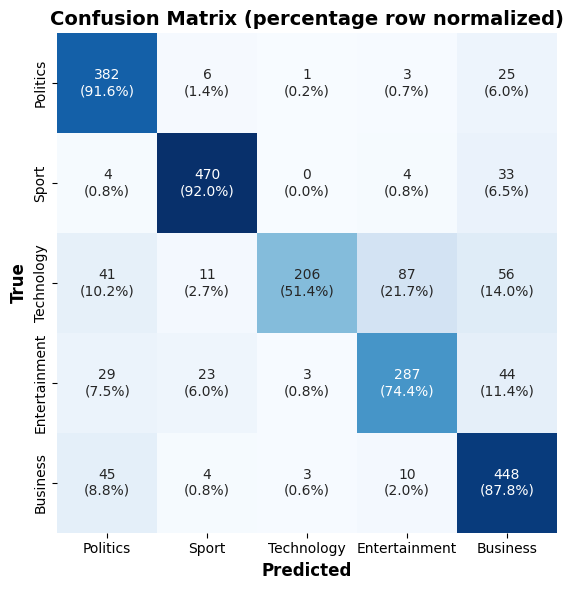

In [12]:
import numpy as np, pandas as pd, seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

id2label = {v:k for k,v in label2id.items()}
_eval = df.dropna(subset=["Predicted"])
y_true = _eval["Label"].astype(int).to_numpy()
y_pred = _eval["Predicted"].astype(int).to_numpy()

classes = sorted(np.unique(np.concatenate([y_true, y_pred])))
names = [id2label.get(c, str(c)) for c in classes]

cm = confusion_matrix(y_true, y_pred, labels=classes)
row_sums = cm.sum(axis=1, keepdims=True).clip(min=1)
cm_pct = (cm / row_sums) * 100

ann = np.empty_like(cm).astype(object)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ann[i, j] = f"{cm[i, j]}\n({cm_pct[i, j]:.1f}%)"

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=ann, fmt="", cmap="Blues", cbar=False, square=True,
            xticklabels=names, yticklabels=names)
plt.xlabel("Predicted", fontweight="bold", fontsize=12)
plt.ylabel("True", fontweight="bold", fontsize=12)
plt.title("Confusion Matrix (percentage row normalized)", fontweight="bold", fontsize=14)
plt.tight_layout(); plt.show()